# Compute parcellated time series and FC from a .dtseries

## Setup

Importage

In [1]:
import os,sys,glob,numpy as np,pandas as pd
import nibabel as nib

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

import seaborn as sns

from nilearn.plotting import plot_surf_stat_map,view_surf

/nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Define some variables

## Load the data

In [2]:
dts_file = '../data/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
dts_img = nib.load(dts_file)
dts_dat = dts_img.get_data()

lab_file =  '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/Gordon333_FreesurferSubcortical.32k_fs_LR.dlabel.nii'
lab_img = nib.load(lab_file)
lab_dat = np.squeeze(lab_img.get_data())

f = '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/S900.sulc_MSMAll.32k_fs_LR.dscalar.nii'
sulc_img = nib.load(f)
sulc_ax1 = sulc_img.header.get_axis(1)
sulc_dat = np.squeeze(sulc_img.get_data())

f = '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/S900.L.inflated_MSMAll.32k_fs_LR.surf.gii'
lhi_img = nib.load(f)
lhi_vtx = lhi_img.darrays[0].data
lhi_tri = lhi_img.darrays[1].data

f = '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/S900.R.inflated_MSMAll.32k_fs_LR.surf.gii'
rhi_img = nib.load(f)
rhi_vtx = rhi_img.darrays[0].data
rhi_tri = rhi_img.darrays[1].data

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Get cifti vertex mapping for surface viz

In [3]:
lh_idxs,rh_idxs = [],[]
for a_it in range(0,sulc_ax1.size):
    el = sulc_ax1.get_element(a_it)
    if el[2] == 'CIFTI_STRUCTURE_CORTEX_LEFT':
        lh_idxs.append([a_it,el[1]])
    elif el[2] == 'CIFTI_STRUCTURE_CORTEX_RIGHT':        
        rh_idxs.append([a_it,el[1]])
lh_idxs = np.array(lh_idxs)
rh_idxs = np.array(rh_idxs)

test it

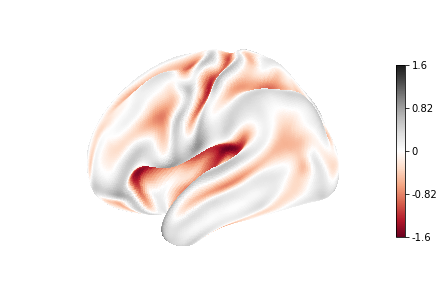

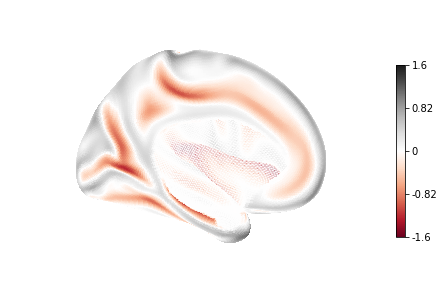

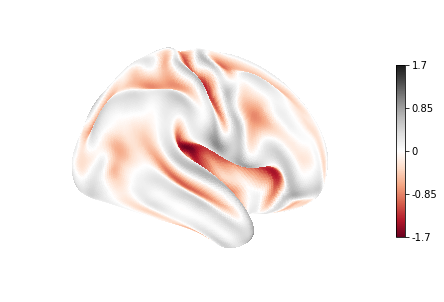

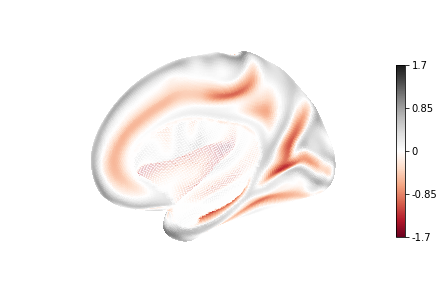

In [ ]:

lh_dat = np.zeros_like(lhi_vtx[:,0])
lh_dat[lh_idxs[:,1]] = sulc_dat[lh_idxs[:,0]]

rh_dat = np.zeros_like(rhi_vtx[:,0])
rh_dat[rh_idxs[:,1]] = sulc_dat[rh_idxs[:,0]]

disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap=cm.RdGy,hemi='left', view='lateral');
disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap=cm.RdGy,hemi='left', view='medial');


disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap=cm.RdGy,hemi='right', view='lateral');
disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap=cm.RdGy,hemi='right', view='medial');

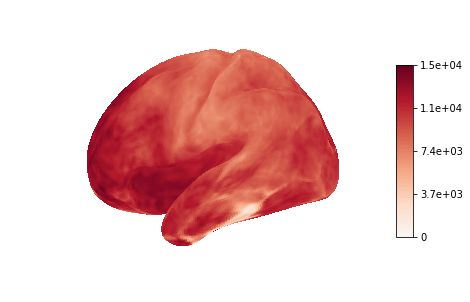

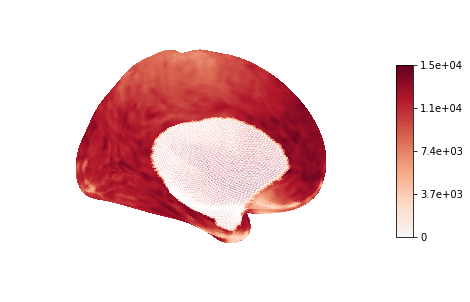

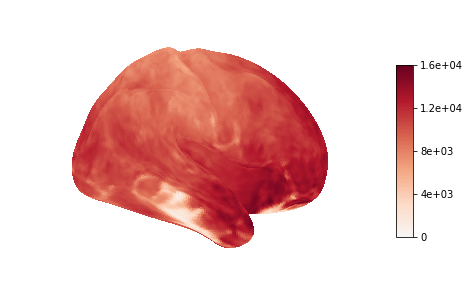

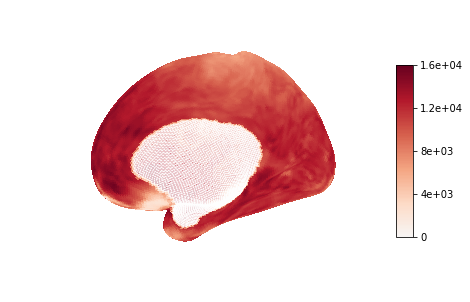

In [14]:
n = 50

lh_dat = np.zeros_like(lhi_vtx[:,0])
lh_dat[lh_idxs[:,1]] = dts_dat.T[lh_idxs[:,0],n]

rh_dat = np.zeros_like(rhi_vtx[:,0])
rh_dat[rh_idxs[:,1]] = dts_dat.T[rh_idxs[:,0],n]

disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='lateral');
disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='medial');


disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='lateral');
disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='medial');

## Compute parcellated time series and conmat

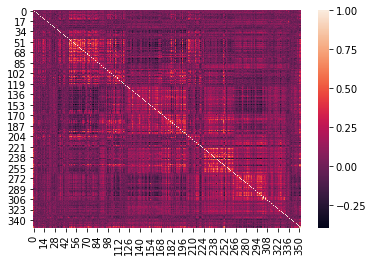

In [4]:
lab_un = np.unique(lab_dat)

pts_dat = np.zeros([dts_dat.shape[0],lab_un.shape[0]])
for l_it,l in enumerate(lab_un):
    idxs = np.nonzero(lab_dat == l)[0]
    pts_dat[:,l_it] = np.mean(dts_dat[:,idxs],axis=1)
pts_corr = np.corrcoef(pts_dat.T)

sns.heatmap(pts_corr)

## View parcellated conmat eigenvectors on surface

In [5]:
evals,evecs = np.linalg.eig(pts_corr)

n_evecs = 10
evecs_onsurf = np.zeros([lab_dat.shape[0],n_evecs])    
for l_it,l in enumerate(lab_un):
    for e_it in range(n_evecs):
        idxs = np.nonzero(lab_dat == l)[0]
        evecs_onsurf[idxs,e_it] = evecs[l_it,e_it] 

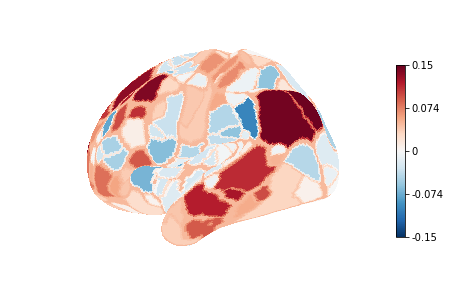

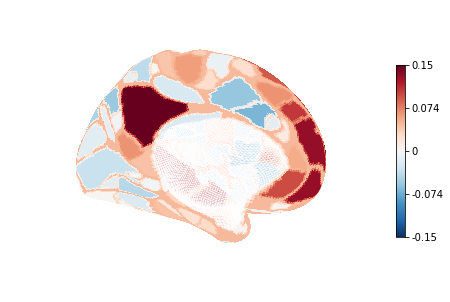

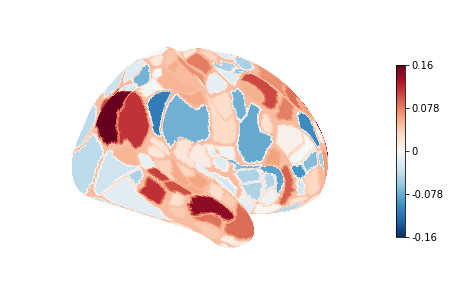

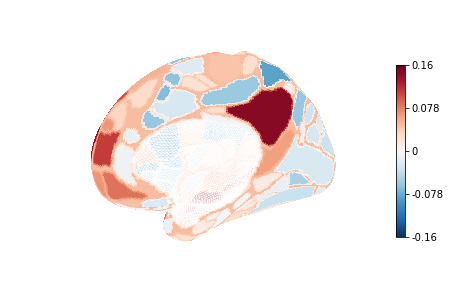

In [6]:
n = 1

lh_dat = np.zeros_like(lhi_vtx[:,0])
lh_dat[lh_idxs[:,1]] = evecs_onsurf[lh_idxs[:,0],n]

rh_dat = np.zeros_like(rhi_vtx[:,0])
rh_dat[rh_idxs[:,1]] = evecs_onsurf[rh_idxs[:,0],n]

disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='lateral');
disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='medial');


disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='lateral');
disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='medial');

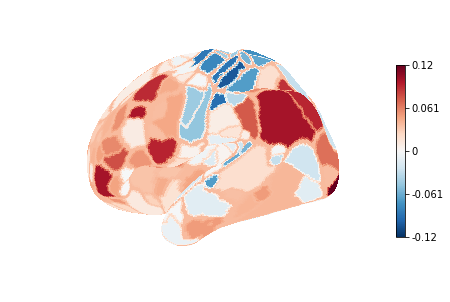

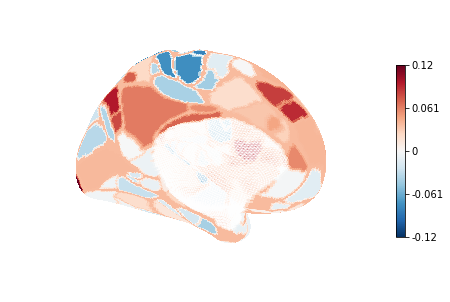

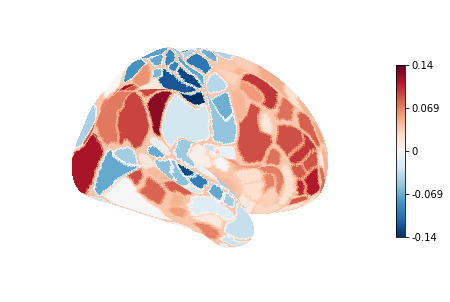

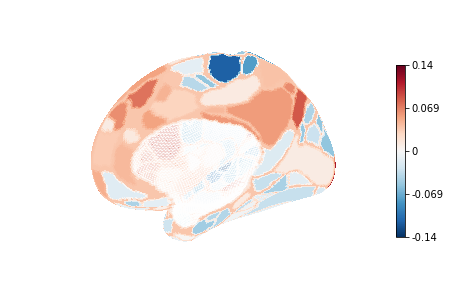

In [7]:
n = 2

lh_dat = np.zeros_like(lhi_vtx[:,0])
lh_dat[lh_idxs[:,1]] = evecs_onsurf[lh_idxs[:,0],n]

rh_dat = np.zeros_like(rhi_vtx[:,0])
rh_dat[rh_idxs[:,1]] = evecs_onsurf[rh_idxs[:,0],n]

disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='lateral');
disp = plot_surf_stat_map([lhi_vtx,lhi_tri],lh_dat,cmap='RdBu_r',hemi='left', view='medial');


disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='lateral');
disp = plot_surf_stat_map([rhi_vtx,rhi_tri],rh_dat,cmap='RdBu_r',hemi='right', view='medial');